## Fraud Detection - Auto Claims
#### In this notebook, we try to identify potential auto fraud claims using predictive modeling techniques. The target variable indicates if the claim was a fraudulent one. The objective of this notebook is to come up with a prediction variable which gives the probability of the filed claim to be a fraudelent one.


### Contents:
    1. Data Preparation
        1.1 Data Import
        1.2 Data Overview Statistics
        1.3 Dropping observation with invalid target values
        1.4 Data Summary
    
    2. Data Preparation
        2.1 Fixing Outliers 
        2.2 Data Imputation using statistical modeling
        2.3 Handling Null Values
            2.3.1 Imputing marital status
            2.3.2 Imputing age of vehicles
            2.3.3 Imputing Claims estimation payout
            2.3.4 Imputing witness present indicator

    3. EDA Analysis   
       3.1 Correlation checks
       3.2 Histograms
       3.3 Density Plots
       3.4 Bivariate analysis

    4. Feature Engineering

    5. Modeling
       5.1 Feature Importance
       5.2 SMOTE Analysis - Training and Validation Set 
       5.3 Training Algorithms - Baseline check
       5.4 Training Algorithms - Standardized Data
       5.5 Model Metrics
       
    6. Model Selection and Test Evaluation

### 1. Data Preparation

#### 1.1 Data Import

In [7]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns

import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('tableau-colorblind10')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, recall_score

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline


In [8]:
rawdata=pd.read_csv(r'..\Data\uconn_comp_2018_train.csv',index_col='claim_number')
print("# of Rows in data:     " + str(rawdata.shape[0]))
print("# of Columns in data:  " + str(rawdata.shape[1]))
print()
print("Sample Data:")
rawdata.head(3)

# of Rows in data:     17998
# of Columns in data:  24

Sample Data:


,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,claim_day_of_week,accident_site,past_num_of_claims,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
claim_number,,,,,,,,,,,,,,,,,,,,,,,,
1,46,M,1.0,85,38301,1,1,Rent,80006,12/16/2016,Friday,Local,1,0.0,74,Broker,0,7530.940993,9.0,Compact,12885.45235,white,16161.33381,0
3,21,F,0.0,75,30445,0,1,Rent,15021,2/12/2015,Thursday,Highway,1,1.0,79,Online,0,2966.024895,4.0,Large,29429.45218,white,28691.96422,0
4,49,F,0.0,87,38923,0,1,Own,20158,12/6/2016,Tuesday,Local,0,0.0,0,Broker,0,6283.888333,3.0,Compact,21701.18195,white,22090.94758,1


#### 1.2 Data Overview Statistics

In [9]:
rawdata.isnull().sum()[rawdata.isnull().sum()>0]

marital_status           5
witness_present_ind    132
claim_est_payout        17
age_of_vehicle           8
dtype: int64

#### Percentage of target variable population

In [10]:
pd.concat([rawdata.groupby('fraud').size(), rawdata.groupby('fraud').size()/len(rawdata)],axis=1).rename(columns={0: 'Count', 1: 'Percentage'})

,Count,Percentage
fraud,,
-1,3,0.000167
0,15179,0.843371
1,2816,0.156462


#### 1.3 Dropping observation with invalid target values
Dropping rows where the target value is -1

In [11]:
rawdata=rawdata[rawdata['fraud']!=-1]
rawdata.groupby('fraud').size()/len(rawdata)

fraud
0    0.843512
1    0.156488
dtype: float64

In [12]:
pd.concat([rawdata.groupby('fraud').size(), rawdata.groupby('fraud').size()/len(rawdata)],axis=1).rename(columns={0: 'Count', 1: 'Percentage'})

,Count,Percentage
fraud,,
0,15179,0.843512
1,2816,0.156488


#### 1.4 Data Summary

In [13]:
rawdata.describe()

,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight,fraud
count,17995.000000,17990.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17863.000000,17995.000000,17995.000000,17978.000000,17987.000000,17995.000000,17995.000000,17995.000000
mean,43.696193,0.712674,73.562879,37367.782940,0.699250,0.577271,49870.288302,0.504918,0.232716,49.429286,0.600778,4975.640673,5.007895,23090.558736,23031.591635,0.156488
std,11.960422,0.452528,15.347390,2957.458451,0.458597,0.494007,29214.181840,0.955504,0.422574,33.677937,0.489752,2215.818263,2.258371,11988.794310,12052.661459,0.363327
min,18.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.639432,0.000000,2457.329316,2429.429302,0.000000
25%,35.000000,0.000000,65.000000,35554.000000,0.000000,0.000000,20111.000000,0.000000,0.000000,17.000000,0.000000,3336.979610,3.000000,14279.686540,14164.267235,0.000000
50%,43.000000,1.000000,76.000000,37610.000000,1.000000,1.000000,50028.000000,0.000000,0.000000,50.000000,1.000000,4668.347789,5.000000,20955.918110,20837.923870,0.000000
75%,51.000000,1.000000,85.000000,39318.000000,1.000000,1.000000,80038.000000,1.000000,0.000000,81.000000,1.000000,6255.744582,6.000000,29563.713610,29429.861945,0.000000
max,229.000000,1.000000,100.000000,54333.000000,1.000000,1.000000,85083.000000,6.000000,1.000000,100.000000,1.000000,17218.345010,16.000000,127063.506000,123016.650400,1.000000


###### Invalid numbers appears to be in fields 'age of driver', 'annual income'

#### 2. Data Preparation

#### 2.1 Fixing Outliers <br> Fixing annual income (values with -1) issue using statistical modeling

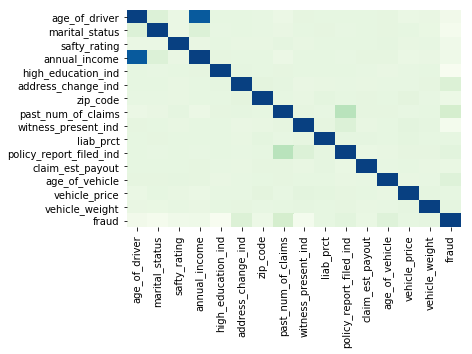

In [14]:
sns.heatmap(rawdata.corr(method='pearson'),cbar=False,cmap='GnBu');

##### Age of driver and Annual Income is highy correlated. This information can be used to impute annual income values when value is -1

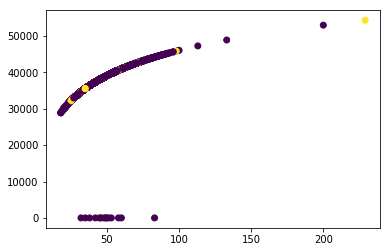

In [15]:
plt.scatter(rawdata['age_of_driver'],rawdata['annual_income'],c=rawdata['fraud']);

#### Creating new age field where we are capping the age at 101 <br> Creating new annual income field where we are capping the annual income to 46200 when age is greater than 100

In [16]:
rawdata.loc[rawdata['age_of_driver']>100,'age_of_driver_new']=101
rawdata.loc[rawdata['age_of_driver']<=100,'age_of_driver_new']=rawdata['age_of_driver']
rawdata['age_of_driver_new']=rawdata['age_of_driver_new'].astype('int64')

In [17]:
rawdata.loc[rawdata['annual_income']>46200,'annual_income_new']=46200
rawdata.loc[rawdata['annual_income']<=46200,'annual_income_new']=rawdata['annual_income']
rawdata['annual_income_new']=rawdata['annual_income_new'].astype('int64')

#### 2.2 Data Imputation using statistical modeling

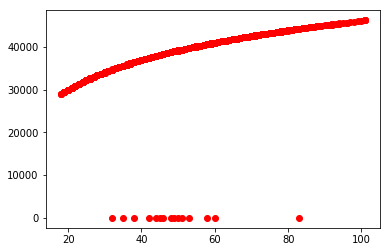

In [18]:
plt.scatter(rawdata['age_of_driver_new'],rawdata['annual_income_new'],c='r');

##### The annual income is -1 for few records. Impute these model using statistical learning

In [19]:
X_train=rawdata['age_of_driver_new'][rawdata['annual_income_new'] != -1].reshape(-1, 1)
X_test=rawdata['age_of_driver_new'][rawdata['annual_income_new'] == -1].reshape(-1, 1)
y_train=rawdata['annual_income_new'][rawdata['annual_income_new'] != -1].reshape(-1, 1)
y_test=rawdata['annual_income_new'][rawdata['annual_income_new'] == -1].reshape(-1, 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17980, 1), (15, 1), (17980, 1), (15, 1))

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [21]:
inc_model=KNeighborsRegressor()
inc_model.fit(X_train,y_train)
inc_pred=inc_model.predict(X_test)

In [22]:
rawdata['inc_pred']=inc_model.predict(rawdata['age_of_driver_new'].reshape(-1, 1))

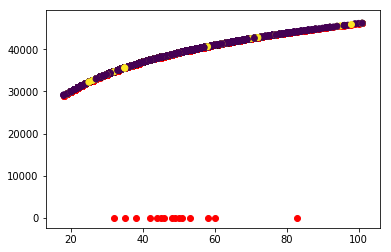

In [23]:
plt.scatter(rawdata['age_of_driver_new'],rawdata['annual_income_new'],c='r');
plt.scatter(rawdata['age_of_driver_new'],rawdata['inc_pred'],c=rawdata['fraud']);

###### *We can see that the prediction overlap with the actual values*

In [24]:
rawdata.loc[rawdata['annual_income']==-1,'annual_income_final']=rawdata['inc_pred']
rawdata.loc[rawdata['annual_income']!=-1,'annual_income_final']=rawdata['annual_income']
rawdata['annual_income_final']=rawdata['annual_income_final'].astype('int64')

In [25]:
# Dropping all intermediate variables
rawdata.drop(['inc_pred','age_of_driver','annual_income','annual_income_new'],axis=1,inplace=True)

#### 2.3 Handling Null Values

In [26]:
rawdata.isnull().sum()[rawdata.isnull().sum() > 0].sort_values()

marital_status           5
age_of_vehicle           8
claim_est_payout        17
witness_present_ind    132
dtype: int64

#### 2.3.1 Imputing marital status

In [27]:
# Imputing missing values for marital status
print(pd.concat([rawdata.groupby('marital_status').size(), rawdata.groupby('marital_status').size()/len(rawdata)],axis=1).rename(columns={0: 'Count', 1: 'Percentage'}))

                Count  Percentage
marital_status                   
0.0              5169    0.287246
1.0             12821    0.712476


In [28]:
# Imputing marital status with value 1 as there are only 5 records with null values and 70% data has value as 1
rawdata['marital_status'].fillna(value=1,inplace=True)

#### 2.3.2 Imputing age of vehicles

In [29]:
# imputing age of vehicle. There are only 8 records. Hence imputing with mean value
rawdata['age_of_vehicle'].fillna(value=5,inplace=True)
rawdata['age_of_vehicle']=rawdata['age_of_vehicle'].astype('int64')

#### 2.3.3 Imputing claim estimation payout

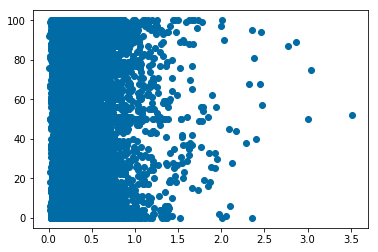

In [30]:
Claim_as_price_Perc=rawdata['claim_est_payout']/rawdata['vehicle_price']
plt.scatter(Claim_as_price_Perc,rawdata['liab_prct']);

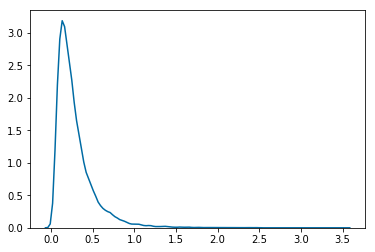

In [31]:
sns.kdeplot(Claim_as_price_Perc);

In [32]:
# imputing claim estimate payout with 30% of the vehicle price
rawdata['claim_est_payout'].fillna(rawdata['vehicle_price']*.3,inplace=True)

#### 4. Imputing witness present indicator

In [33]:
# Imputing missing values for witness_present_ind
print(pd.concat([rawdata.groupby('witness_present_ind').size(), rawdata.groupby('witness_present_ind').size()/len(rawdata)],axis=1).rename(columns={0: 'Count', 1: 'Percentage'}))

                     Count  Percentage
witness_present_ind                   
0.0                  13706    0.761656
1.0                   4157    0.231009


In [34]:
rawdata['witness_present_ind'].fillna(value=0,inplace=True)

### 3. EDA Analysis

#### 3.1 Correlation Checks

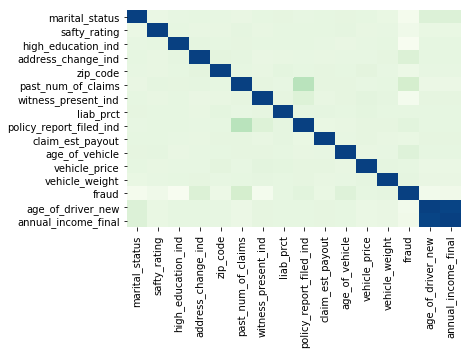

In [35]:
sns.heatmap(rawdata.corr(method='pearson'),cbar=False,cmap='GnBu');

#### 3.2 Histograms

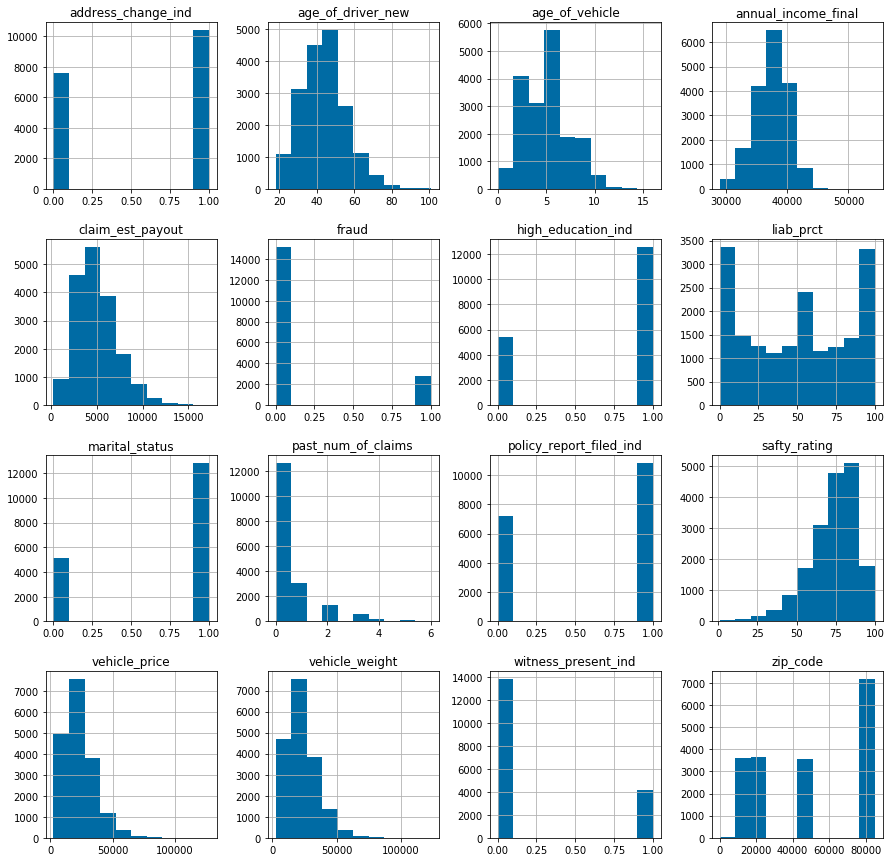

In [36]:
rawdata.hist(figsize=[15,15]);

#### 3.3 Density Plots

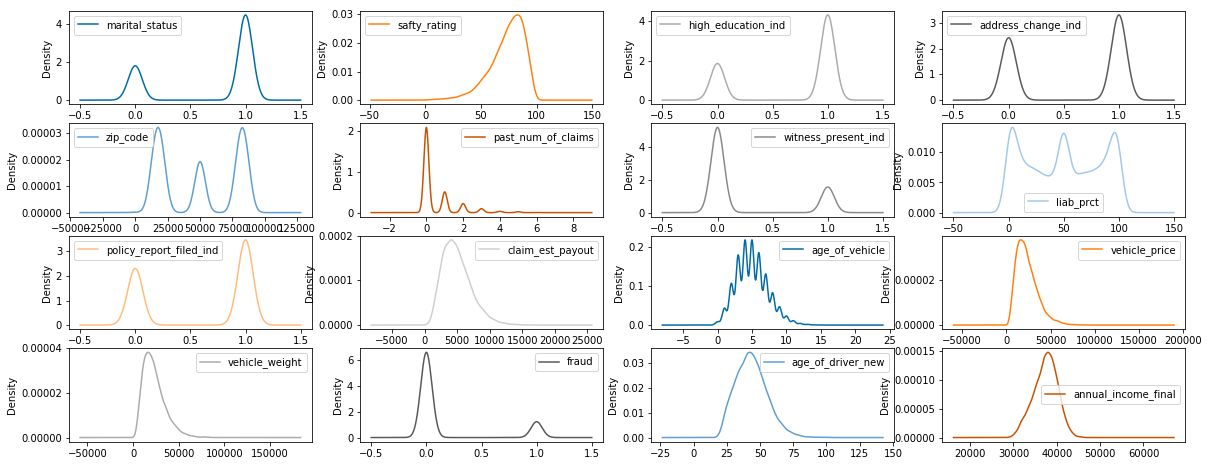

In [37]:
rawdata.plot(kind='density',subplots=True,figsize=(20,10),layout=[5,4],sharex=False,sharey=False);

#### 3.4 Bivariate analysis

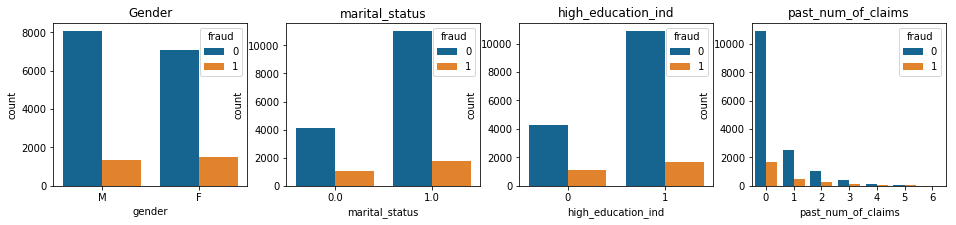

In [38]:
fig, ax=plt.subplots(1,4,figsize=(16,3))
ax[0].set_title('Gender')
sns.countplot('gender',hue='fraud',data=rawdata,ax=ax[0])
ax[1].set_title('marital_status')
sns.countplot('marital_status',hue='fraud',data=rawdata,ax=ax[1])
ax[2].set_title('high_education_ind')
sns.countplot('high_education_ind',hue='fraud',data=rawdata,ax=ax[2])
ax[3].set_title('past_num_of_claims')
sns.countplot('past_num_of_claims',hue='fraud',data=rawdata,ax=ax[3]);

### 4. Feature Engineering

In [39]:
rawdata['gender'] = np.where(rawdata['gender']=='M',1,0)
rawdata['state_id']=rawdata['zip_code'].astype('str').str[0:2].astype('int64')

In [40]:
rawdata['Weekday_ind']=np.where((rawdata['claim_day_of_week']=='Saturday')|(rawdata['claim_day_of_week']=='Sunday'),0,1)
rawdata['Ratio_claim_pay_price']=rawdata['claim_est_payout']/rawdata['vehicle_price']

In [41]:
data=rawdata.copy()
data['age_of_driver_new']=pd.cut(data['age_of_driver_new'],bins=[0,30, 50, 70, 90,102])
data=pd.get_dummies(data,columns=['living_status','accident_site','channel','vehicle_category'],drop_first=True,prefix_sep='_')
#data.drop(['zip_code','claim_date','claim_est_payout','vehicle_price','state_id','channel','policy_report_filed_ind','vehicle_weight','vehicle_color','vehicle_category','liab_prct'],axis=1,inplace=True)
data.drop(['zip_code','claim_date','age_of_driver_new','claim_day_of_week','vehicle_color'],axis=1,inplace=True)

In [42]:
X=data.drop('fraud',axis=1)
y=data['fraud']
print(X.shape)
print(y.shape)
scaler=Normalizer()
X_Scaled=scaler.fit_transform(X)
X_Scaled.shape

(17995, 24)
(17995,)


(17995, 24)

### 5. Modeling

#### 5.1 Feature Importance

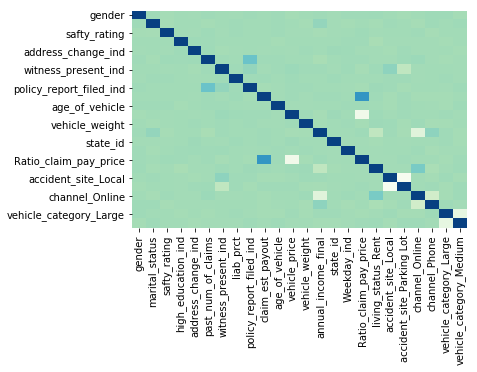

In [43]:
sns.heatmap(X.corr(method='pearson'),cbar=False,cmap='GnBu');

In [44]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  fraud   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     56.54
Date:                Mon, 25 Feb 2019   Prob (F-statistic):          1.34e-261
Time:                        20:16:13   Log-Likelihood:                -6659.2
No. Observations:               17995   AIC:                         1.337e+04
Df Residuals:                   17970   BIC:                         1.356e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

#### 5.2 SMOTE Analysis - Training and Validation Set

In [45]:
# Actual split of train and test data
seed=42
validation_size=0.2
xtrain, xtest, ytrain, ytest=train_test_split(X,y,test_size=validation_size,random_state=seed)

# Splitting train data again to apply SMOTE
xtrain_sm, x_val, ytrain_sm, y_val = train_test_split(xtrain, ytrain,test_size =validation_size,random_state=seed)

sm = SMOTE(random_state=seed, ratio =1)
xtrain_res, ytrain_res = sm.fit_sample(xtrain_sm, ytrain_sm)

#### 5.3 Training Algorithms - Baseline check   

In [185]:
results=[]
names=[]
models=[]
models.append(("LR",LogisticRegression()))
models.append(("LDA",LinearDiscriminantAnalysis()))
models.append(("NB",GaussianNB()))

In [186]:
for name, model in models:
    model=model
    model.fit(xtrain_res,ytrain_res)
    names.append(name)
    y_pred=model.predict(xtest)
    y_prob=model.predict_proba(xtest)    
    print('--------------------------------------------------------')
    print(name, roc_auc_score(ytest,y_pred))
    print('Validation Results')
    print('Model Score',model.score(x_val, y_val))
    print('Recall Score',recall_score(y_val, model.predict(x_val)))
    print('\nTest Results')
    print('Model Score',model.score(xtest, ytest))
    print('Recall Score',recall_score(ytest, model.predict(xtest)))
    print('\nConfusion Matrix\n',confusion_matrix(ytest,y_pred))
    print('\nClassification Report\n',classification_report(ytest,y_pred))
    

--------------------------------------------------------
LR 0.5140685335371604
Validation Results
Model Score 0.4808641975308642
Recall Score 0.5871212121212122

Test Results
Model Score 0.4672222222222222
Recall Score 0.5801526717557252

Confusion Matrix
 [[689 849]
 [110 152]]

Classification Report
               precision    recall  f1-score   support

           0       0.86      0.45      0.59      1538
           1       0.15      0.58      0.24       262

   micro avg       0.47      0.47      0.47      1800
   macro avg       0.51      0.51      0.42      1800
weighted avg       0.76      0.47      0.54      1800

--------------------------------------------------------
LDA 0.6620226525973059
Validation Results
Model Score 0.6567901234567901
Recall Score 0.6818181818181818

Test Results
Model Score 0.6388888888888888
Recall Score 0.6946564885496184

Confusion Matrix
 [[968 570]
 [ 80 182]]

Classification Report
               precision    recall  f1-score   support

         

#### 5.4 Training Algorithms - Standardized Data

In [46]:
ensembles = []
ensembles.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
ensembles.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA',LinearDiscriminantAnalysis())])))
ensembles.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',GaussianNB())])))


#### 5.5 Model Metrics

In [920]:
for name, model in ensembles:
    model=model
    model.fit(xtrain_res,ytrain_res)
    names.append(name)
    y_pred=model.predict(xtest)
    y_prob=model.predict_proba(xtest)    
    print('--------------------------------------------------------')
    print(name, roc_auc_score(ytest,y_pred))
    print('Validation Results')
    print('Model Score',model.score(x_val, y_val))
    print('Recall Score',recall_score(y_val, model.predict(x_val)))
    print('\nTest Results')
    print('Model Score',model.score(xtest, ytest))
    print('Recall Score',recall_score(ytest, model.predict(xtest)))
    print('\nConfusion Matrix\n',confusion_matrix(ytest,y_pred))
    print('\nClassification Report\n',classification_report(ytest,y_pred))

--------------------------------------------------------
ScaledLR 0.6490733479585861
Validation Results
Model Score 0.6604938271604939
Recall Score 0.6590909090909091

Test Results
Model Score 0.6411111111111111
Recall Score 0.6603053435114504

Confusion Matrix
 [[981 557]
 [ 89 173]]

Classification Report
              precision    recall  f1-score   support

          0       0.92      0.64      0.75      1538
          1       0.24      0.66      0.35       262

avg / total       0.82      0.64      0.69      1800

--------------------------------------------------------
ScaledLDA 0.6487060622003394
Validation Results
Model Score 0.6592592592592592
Recall Score 0.6590909090909091

Test Results
Model Score 0.6377777777777778
Recall Score 0.6641221374045801

Confusion Matrix
 [[974 564]
 [ 88 174]]

Classification Report
              precision    recall  f1-score   support

          0       0.92      0.63      0.75      1538
          1       0.24      0.66      0.35       262

avg

#### 6. Model Selection and Test Evaluation

In [175]:
model=LinearDiscriminantAnalysis()
model.fit(xtrain_res,ytrain_res)
y_pred=model.predict(xtest)
print('--------------------------------------------------------')
print(roc_auc_score(ytest,y_pred))
print('Validation Results')
print('Model Score',model.score(x_val, y_val))
print('Recall Score',recall_score(y_val, model.predict(x_val)))
print('\nTest Results')
print('Model Score',model.score(xtest, ytest))
print('Recall Score',recall_score(ytest, model.predict(xtest)))
roc_auc_score(ytest,y_pred)
print(confusion_matrix(ytest,y_pred))
print(classification_report(ytest,y_pred))

--------------------------------------------------------
0.6620226525973059
Validation Results
Model Score 0.6567901234567901
Recall Score 0.6818181818181818

Test Results
Model Score 0.6388888888888888
Recall Score 0.6946564885496184
[[968 570]
 [ 80 182]]
              precision    recall  f1-score   support

           0       0.92      0.63      0.75      1538
           1       0.24      0.69      0.36       262

   micro avg       0.64      0.64      0.64      1800
   macro avg       0.58      0.66      0.55      1800
weighted avg       0.82      0.64      0.69      1800



#### 7. Model Predictions

In [176]:
pred_data=pd.read_csv(r'..\Data\uconn_comp_2018_test.csv',index_col='claim_number')
pred_data.head()

pred_data.loc[pred_data['age_of_driver']>100,'age_of_driver_new']=101
pred_data.loc[pred_data['age_of_driver']<=100,'age_of_driver_new']=pred_data['age_of_driver']
pred_data['age_of_driver_new']=pred_data['age_of_driver_new'].astype('int64')

pred_data.loc[pred_data['annual_income']>46200,'annual_income_new']=46200
pred_data.loc[pred_data['annual_income']<=46200,'annual_income_new']=pred_data['annual_income']
pred_data['annual_income_new']=pred_data['annual_income_new'].astype('int64')

pred_data['inc_pred']=inc_model.predict(pred_data['age_of_driver_new'].reshape(-1, 1))

pred_data.loc[pred_data['annual_income']==-1,'annual_income_final']=pred_data['inc_pred']
pred_data.loc[pred_data['annual_income']!=-1,'annual_income_final']=pred_data['annual_income']
pred_data['annual_income_final']=pred_data['annual_income_final'].astype('int64')

# Dropping all intermediate variables
pred_data.drop(['inc_pred','age_of_driver','annual_income','annual_income_new'],axis=1,inplace=True)
pred_data['marital_status'].fillna(value=1,inplace=True)

pred_data['age_of_vehicle'].fillna(value=5,inplace=True)
pred_data['age_of_vehicle']=pred_data['age_of_vehicle'].astype('int64')

# imputing claim estimate payout with 30% of the vehicle price
pred_data['claim_est_payout'].fillna(pred_data['vehicle_price']*.3,inplace=True)

# Imputing missing values for witness_present_ind
pred_data['witness_present_ind'].fillna(value=0,inplace=True)

pred_data['gender'] = np.where(pred_data['gender']=='M',1,0)
pred_data['state_id']=pred_data['zip_code'].astype('str').str[0:2].astype('int64')

pred_data['Weekday_ind']=np.where((pred_data['claim_day_of_week']=='Saturday')|(pred_data['claim_day_of_week']=='Sunday'),0,1)
pred_data['Ratio_claim_pay_price']=pred_data['claim_est_payout']/pred_data['vehicle_price']

X=pd.get_dummies(pred_data,columns=['living_status','accident_site','channel','vehicle_category'],drop_first=True,prefix_sep='_')
X.drop(['zip_code','claim_date','age_of_driver_new','claim_day_of_week','vehicle_color'],axis=1,inplace=True)
X.head()

scaler=Normalizer()
X_Scaled=scaler.fit_transform(X)



Y_pred=clf.predict_proba(X, ntree_limit=clf.best_iteration)
X['fraud']=Y_pred[:,1]
X.head()

In [178]:
X['fraud']=model.predict_proba(X_Scaled)[:,1]
X.head()

,gender,marital_status,safty_rating,high_education_ind,address_change_ind,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight,annual_income_final,state_id,Weekday_ind,Ratio_claim_pay_price,living_status_Rent,accident_site_Local,accident_site_Parking Lot,channel_Online,channel_Phone,vehicle_category_Large,vehicle_category_Medium,fraud
claim_number,,,,,,,,,,,,,,,,,,,,,,,,,
2,1,1.0,73,1,0,0,0.0,25,0,5196.552552,8,24360.59273,26633.27819,36633,50,1,0.213318,0,0,0,0,1,1,0,0.412826
9,1,1.0,63,1,1,0,1.0,50,1,7381.165248,6,39710.42665,15875.34874,40252,85,1,0.185875,0,0,0,0,0,1,0,0.331731
11,0,0.0,75,1,1,0,0.0,98,1,5612.123938,7,50327.56618,21365.05932,36634,20,1,0.111512,0,0,1,0,0,0,1,0.496797
13,1,1.0,72,0,1,0,1.0,45,0,7957.267641,2,23457.35282,26707.46021,34960,50,0,0.339223,0,1,0,0,1,0,1,0.296448
14,0,1.0,70,1,1,0,1.0,11,0,6232.195932,1,18238.39202,22949.73744,31776,20,0,0.341708,1,1,0,1,0,0,1,0.244249
